# **`flygym`-MuJoCo exercise: Decentralized controller** 

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_decentralized_ctrl_exercise.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).

In particular, you're encouraged to go through [the tutorial on decentralized control]() proceeding with this exercise:

In [11]:
#@title Install `flygym` on Colab

# This block is modified from dm_control's tutorial notebook
# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

print('Installing flygym')
!pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during dm_control installation. Check the shell '
        'output above for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

print('Checking that the flygym installation succeeded...')
try:
    import flygym
    from flygym import envs
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during flygym installation. Check the shell '
        'output above for more information.\n')
else:
    del envs, flygym 

'#@title Install `flygym` on Colab\n\n# This block is modified from dm_control\'s tutorial notebook\n# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb\n\nimport subprocess\nif subprocess.run(\'nvidia-smi\').returncode:\n    raise RuntimeError(\n        \'Cannot communicate with GPU. \'\n        \'Make sure you are using a GPU Colab runtime. \'\n        \'Go to the Runtime menu and select Choose runtime type.\')\n\nprint(\'Installing flygym\')\n!pip install -q --progress-bar=off \'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git@decentralized_ctrl\'\n\n# Configure dm_control to use the EGL rendering backend (requires GPU)\n%env MUJOCO_GL=egl\n\nprint(\'Checking that the dm_control installation succeeded...\')\ntry:\n    from dm_control import suite\n    env = suite.load(\'cartpole\', \'swingup\')\n    pixels = env.physics.render()\nexcept Exception as e:\n    raise e from RuntimeError(\n        \'Something went wrong during dm_control installation. Check the 

---

This notebook should serve as a draft to implement your own decentralized complex-terrain-proof controller. We will first analyze how the simple decentralized controller is doing against complex terrain.

It will then be your work to use either the Cruse rules or your own rule to make the controller complex-terrain-proof.
As a reminder the Cruse rules coupling looks like this:
<img src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/cruse_rules.png" alt="CruseRules" width="500"> <figcaption>Source: M.Shilling, H.Cruse https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009362</figcaption>

In particular, you will have to implement a function compute_score in a similar fashion to the one implemented in the [the tutorial on decentralized control](). This function takes as input the state of the legs (could be composed of contact forces, end-effector positions, stepping advancement and maybe joint angles) and returns a score that could be interpereted as the probability of initiating a step in a leg. The weighting in the summation of those rules will need to be tuned to shape your desired behavior. Stepping will then be applied to the NeuroMechFly instance you collected the state from. You will probably need to implement an update stepping advancement fonction that depending on the state or the leg score, will update the advancement of the step. Note that there is no need to go through the stepping linerarly. Some regions of the step can be accelerated and some can be slowed down. You can decide to make use of the rules proposal implemented later in this notebook or not.

Similar to the previous demos, we start by initializing the simulation environment:

# Complex terrain locomotion

In [24]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

from scipy.signal import medfilt

import PIL.Image

In [31]:
# Initialize simulation
run_time = 1
out_dir = Path('../decentralized_ctrl')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': (0, 0, 300),
                  'friction': (friction, 0.005, 0.0001)}

nmf_gapped = NeuroMechFlyMuJoCo(render_mode='saved',
                         terrain = "blocks",
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera':"Animat/camera_left"},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         physics_config=physics_config,
                         terrain_config=terrain_config)

num_steps_base = int(run_time / nmf_gapped.timestep)


## Load step data define helper variables

In [32]:
# Load the data, the step_timing and the number of stabilisation steps
with open(out_dir / "manual_corrected_data.pickle", 'rb') as handle:
    step_data_block_manualcorrect, leg_swing_starts, leg_stance_starts, n_steps_stabil = pickle.load(handle)

interp_step_duration = np.shape(step_data_block_manualcorrect)[1]
# Initialize simulation
n_stabilisation_steps = n_steps_stabil
# Run the simulation for a few steps to stabilise the system before starting the contoller
num_steps = num_steps_base + n_stabilisation_steps

#Define rule variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf_gapped.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf_gapped.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)
rule1_corresponding_legs = {"LH":["LM"], "LM":["LF"], "LF":[], "RH":["RM"], "RM":["RF"], "RF":[]}
rule2_corresponding_legs = {"LH":["LM", "RH"], "LM":["LF", "RM"], "LF":["RF"], "RH":["RM", "LH"], "RM":["RF", "LM"], "RF":["LF"]}
rule3_corresponding_legs = {"LH":["RH"], "LM":["LH", "RM"], "LF":["LM", "RF"], "RH":["LH"], "RM":["RH", "LM"], "RF":["LF", "RM"]}

#Rule 1 should supress lift off (if a leg is in swing coupled legs should not be lifted most important leg to guarantee stability)
rule1_weight = -1e4
#Rule 2 should facilitate early protraction (upon touchdown of a leg coupled legs are encouraged to swing)
rule2_weight = 2.5
rule2_weight_contralateral = 1
#Rule 3 should enforce late protraction (the later in the stance the more it facilitates stance initiation)
rule3_weight = 3
rule3_weight_contralateral = 2

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# one percent margin if leg score within this margin to the max score random choice between the very likely legs
percent_margin = 0.001

# For each leg the ids of the force sensors that are attached to it
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf_gapped.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg):
            leg_force_sensors_ids[leg].append(i)   

## Define helper functions

In [33]:
def update_stepping_advancement(stepping_advancement, legs, interp_step_duration):
    for k, leg in enumerate(legs):
        if stepping_advancement[k] >= interp_step_duration-1:
            stepping_advancement[k] = 0
        elif stepping_advancement[k] > 0:
            stepping_advancement[k] +=1
    return stepping_advancement

def compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                       rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                       rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                       stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration):
    leg_scores = np.zeros(len(legs))
    
    #Iterate through legs to compute score
    for k, leg in enumerate(legs):        
        # For the first rule
        leg_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]]] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)
        all_legs_rule1_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]], i] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)       
        
        #For the second rule strong contact force happens at the beggining of the stance phase
        for l in rule2_corresponding_legs[leg]:
            if l[0] == leg[0]:
                #ipsilateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                #contralateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

        #For the third rule
        for l in rule3_corresponding_legs[leg]:
            if l[0] == leg[0]:
                leg_scores[leg_corresp_id[l]] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                leg_scores[leg_corresp_id[l]] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

    return leg_scores

In [34]:
np.random.seed(42)

num_steps = n_stabilisation_steps + num_steps_base

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# one percent margin if leg score within this margin to the max score random choice between the very likely legs
percent_margin = 0.001

obs_list_cruse_gapped = []
all_initiated_legs = []

#Run the actual simulation
for i in trange(num_steps):

    #Decide in which leg to step
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1) or stepping_advancement[initiating_leg] > 0:
        initiating_leg = None
    else:
        stepping_advancement[initiating_leg] += 1
        all_initiated_legs.append([initiating_leg, i])
    
    joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
    action = {'joints': joint_pos}
    obs, info = nmf_gapped.step(action)
    nmf_gapped.render()
    obs_list_cruse_gapped.append(obs)

    stepping_advancement = update_stepping_advancement(stepping_advancement, legs, interp_step_duration)

    leg_scores = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                    rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                    rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                    stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration)
        
    all_leg_scores[:, i] = leg_scores

nmf_gapped.save_video(out_dir / 'cruse_gapped.mp4')
nmf_gapped.close()

distances = obs_list_cruse_gapped[n_stabilisation_steps]["fly"][0][:2] - obs_list_cruse_gapped[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

100%|██████████| 14792/14792 [00:33<00:00, 440.11it/s]


Forward distance travelled:  4212.572434819815
Lateral distance travelled:  -2337.281441676696


In [35]:
from ipywidgets import Video
Video.from_file(out_dir / 'cruse_gapped.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

Here this approach is failling. There are multiple reasons for this. In this implementation the stepping probability does not depend on the situation. Swing and stance durations are hard coded and not flexible. One of the most important rule to guaranty stability using the Cruse rules is the first rule. When a leg is in swing the neighbours can not swing. In the current implementation when the leg falls in a hole the neighbouring legs escape inhibition if the swing counter comes to an end. As a result the center of gravity of the fly gets lower and lower and it is now impossible to get the midleg unstuck. Ideally the ipsilateral legs would have been inhibitted and the midleg would have stepped again.

This rule can be implemented as we have access to the contact forces.
In addition to those three first rules we will implement rule 5 also based on force feedback to make the gait more reliable

Another interpretation of the Cruse rules could be:

- Rule 1: When one leg is in swing the coupled legs are inhibited (swing monitored through contact forces)
- Rule 2: In the beginning of the stance period, coupled leg are encouraged to step (early stance <=> phase of increasing load)
- Rule 3: When approaching the end of the stance coupled leg are forced to step (late stance <=> phase of decreasing load)
- Rule 5: Distribute the weight; If the weight increases in one leg prolong the stance in the other legs

# Define Cruse rules in term of contact force feedback

## Compute the contact forces from the previous experiment

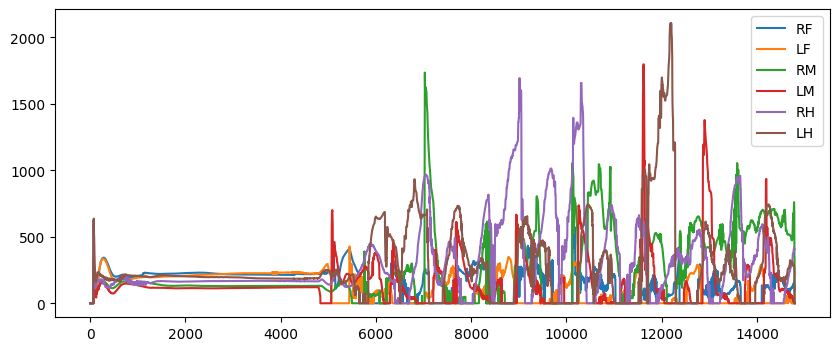

In [21]:
# Lets test the rules on the contact forces from the previous simulation

all_legs_contact_forces = []

for obs in obs_list_cruse_gapped:
    all_legs_contact_forces.append([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])

# Median filter the contact forces as the readout can be very noisy
all_legs_contact_forces = medfilt(all_legs_contact_forces, kernel_size=(21, 1))

plt.figure(figsize=(10, 4))
plt.plot(all_legs_contact_forces, label = legs)
plt.legend()
plt.show()


## Proposition of activation rules

In [22]:
def activate_rule1(leg_contact_forces, i, window_size=20):
     # Activated if the leg is in swing for a couple of steps
    if i < window_size:
         window_size = i
    return np.all(leg_contact_forces[i-window_size:i] <= 0)

def activate_rule2(leg_contact_forces, i, leg_touchdown_counter, touchdown_duration=100, window_size=10):
    # This rule is active if the contact force was zero for a couple of steps and then it increases
    # The duration of this effect is fixed by the touchdown_duration

    if i < window_size:
         window_size = i

    if leg_touchdown_counter == touchdown_duration:
            leg_touchdown_counter = 0
    
    if leg_touchdown_counter <= 0 and leg_contact_forces[i] > 0 and np.all(leg_contact_forces[i-window_size:i-1] <= 0): # add stepping advancement > 0
        leg_touchdown_counter += 1
        return True, leg_touchdown_counter
    
    if leg_touchdown_counter > 0:
        leg_touchdown_counter += 1
        return True, leg_touchdown_counter
    else:
        return False, leg_touchdown_counter

def rule3_contribution(leg_contact_forces, i, leg_last_max_stance_force, time_since_last_max_stance, window_size=20):
    #This function returns the contribution of the rule 3 to the leg score
    #The contribution increases as the contact force decreases (i.e the leg is comming closer to the end of the stance)
    #If the contact force goes up again, the contribution is reset to zero
    #If the leg is in stance again for a couple of steps, the contribution is reset to zero
    # The contribution is the difference between the last max stance force and the current contact force last max stance force should be the max contact force during the stance

    contribution = 0
    if i < window_size:
         window_size = i

    # if the counter was ON and the leg is in swing or the load is increasing again, reset the counter (return 0, 0, 0)
    if (np.all(leg_contact_forces[i-window_size:i] <= 0) or np.median(np.diff(leg_contact_forces[i-window_size:i])) > 0 and time_since_last_max_stance > 0):
            return contribution, 0, 0
    # if the contact force is deceasing 
    if  np.median(np.diff(leg_contact_forces[i-window_size:i])) < 0 and time_since_last_max_stance <= 0: # add stepping advancement > 0
        leg_last_max_stance_force = leg_contact_forces[i]
        contribution = leg_last_max_stance_force - leg_contact_forces[i]
    
    if leg_last_max_stance_force > 0:
        contribution = leg_last_max_stance_force - leg_contact_forces[i]
        return contribution if contribution > 0 else 0, leg_last_max_stance_force, time_since_last_max_stance + 1
    else:
        return contribution, 0, 0
    
    
def rule5_decrease_increase_timestep(leg_contact_forces, i, counter_since_last_increase, prev_output, min_decrease_interval=50, window_size=10):
    #This function send a 1 if the step size should be decreases it returns -1 if the step size can be increased again
    #The function waits for a couple of steps before seding the signal to decrease the step size again

    step_size_action = 0
    if i < window_size:
        window_size = i

    if counter_since_last_increase < min_decrease_interval:
        counter_since_last_increase += 1
    else:
        counter_since_last_increase = 0
        if np.median(np.diff(leg_contact_forces[i-window_size:i])) < 1 and  prev_output == 1:
            step_size_action = -1

    if np.median(np.diff(leg_contact_forces[i-window_size:i])) > 1 and  counter_since_last_increase == 0:
        step_size_action = 1
        counter_since_last_increase += 1
    
    return step_size_action, counter_since_last_increase


## Test the rules on previous simulation

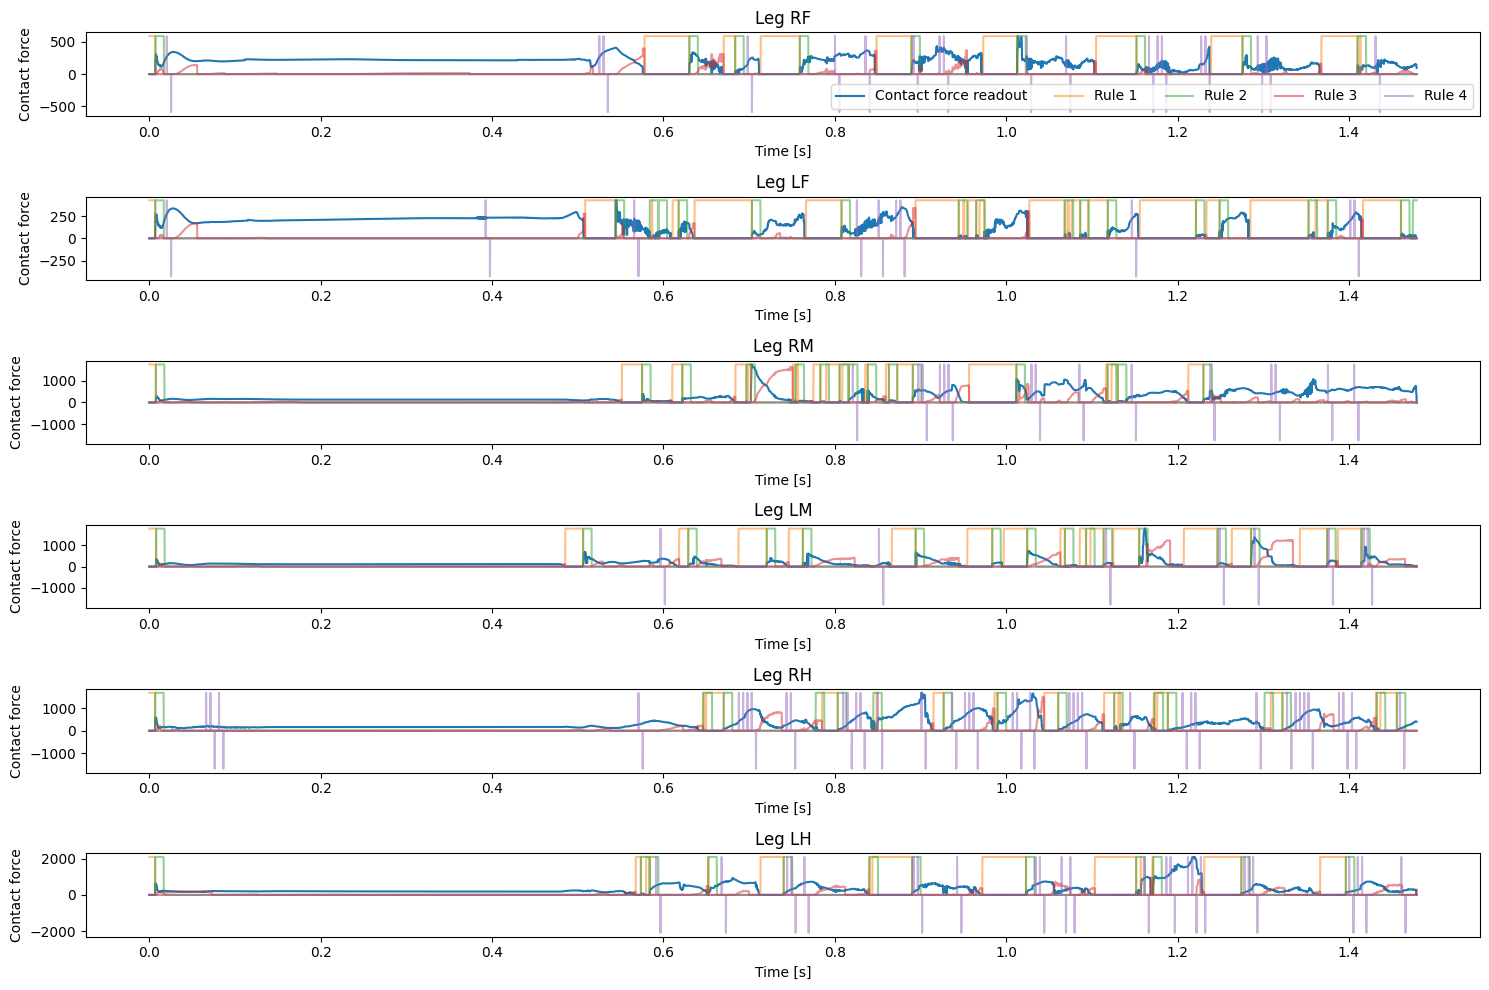

In [23]:
time = np.arange(0, num_steps, 1)*nmf_gapped.timestep

rule1_isactive_legs = np.zeros((len(legs), num_steps))

rule2_isactive_legs = np.zeros((len(legs), num_steps))
leg_touchdown_counter = np.zeros(len(legs))

rule3_contributions_legs = np.zeros((len(legs), num_steps))
leg_last_max_stance_force = np.zeros(len(legs))
time_since_last_max_stance = np.zeros(len(legs)) 

rule5_step_size_action = np.zeros((len(legs), num_steps))
counter_since_last_increase = np.zeros(len(legs))
legs_prev_step_size_action = np.zeros(len(legs))

for i in range(num_steps):
    for l, leg in enumerate(legs):
        rule1_isactive_legs[l, i] = activate_rule1(all_legs_contact_forces[:, l], i)
        rule2_isactive_legs[l, i], leg_touchdown_counter[l] = activate_rule2(all_legs_contact_forces[:, l], i, leg_touchdown_counter[l])
        rule3_contributions_legs[l, i], leg_last_max_stance_force[l], time_since_last_max_stance[l] = rule3_contribution(all_legs_contact_forces[:, l],
                                                                                                              i, leg_last_max_stance_force[l], time_since_last_max_stance[l])
        rule5_step_size_action[l, i], counter_since_last_increase[l] = rule5_decrease_increase_timestep(all_legs_contact_forces[:, l], i, counter_since_last_increase[l], legs_prev_step_size_action[l])
        legs_prev_step_size_action[l] = rule5_step_size_action[l, i] if not rule5_step_size_action[l, i] == 0 else legs_prev_step_size_action[l]

# Plot the contact force and the the rule conditions
fig, axs = plt.subplots(len(legs), 1, figsize=(15, 10))
for l, leg in enumerate(legs):
    axs[l].plot(time, all_legs_contact_forces[:, l], label = f"Contact force readout")
    visu_scaling = np.max(all_legs_contact_forces[:, l])
    axs[l].plot(time, rule1_isactive_legs[l, :]*visu_scaling, label = "Rule 1", alpha =0.5)
    axs[l].plot(time, rule2_isactive_legs[l, :]*visu_scaling, label = "Rule 2", alpha =0.5)
    axs[l].plot(time, rule3_contributions_legs[l, :]*1, label = "Rule 3", alpha =0.5)
    axs[l].plot(time, rule4_step_size_action[l, :]*visu_scaling, label = "Rule 4", alpha =0.5)
    if l == 0:
        axs[l].legend(loc = "lower right", ncol=5)
    axs[l].set_xlabel("Time [s]")
    axs[l].set_ylabel("Contact force")
    axs[l].set_title(f"Leg {leg}")

fig.tight_layout()

Given those simple implementations of the Cruse rules based on force feedback can you combine them to get a complex-terrain-proof controller. Feel free to modify those functions and come up with new rules.


Those functions are not taking into account the stepping advancement. Introducing this variable might make the controller more robust.


Tips:
- Increasing the stance duration could be performed by incrementing the stepping advancement only by a fraction of one. Reading from the joint angles could be done using the np.round function. A cleaner way of doing that could be to interpolate between points in the joint angles.
- Visualize both the gait and the evolution of the score. What leg should be stepping? Why is it not? Implement rules encouraging the desired stepping. 
- Reducing the number of degrees of freedom for the step might be usefull. Feel free to engineer your own (simpler and probably unrealistic) stepping function.